In [65]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [66]:
import pandas as pd
from polygon import RESTClient
import time

API_KEY = "qZjobWEw7wU6mutIdeE19pDHXcPzbp4R"

client = RESTClient(API_KEY)

tickers = ["DHI", "LEN", "PHM", "TOL", "VNO", "SPG"]
start_date = "2023-03-01"
end_date = "2024-03-01"

data_dict = {}

for ticker in tickers:
    try:
        bars = client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_=start_date, to=end_date)
        df = pd.DataFrame(bars)
        df["date"] = pd.to_datetime(df["timestamp"], unit="ms")  # Convert timestamp to date
        df.set_index("date", inplace=True)
        data_dict[ticker] = df["close"]
        print(f"✅ Downloaded data for {ticker}")
        time.sleep(1)  # Prevent hitting rate limits
    except Exception as e:
        print(f"❌ Failed to download {ticker}: {e}")

data = pd.DataFrame(data_dict)

data.head()

✅ Downloaded data for DHI
✅ Downloaded data for LEN
✅ Downloaded data for PHM
✅ Downloaded data for TOL
✅ Downloaded data for VNO
❌ Failed to download SPG: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/SPG/range/1/day/2023-03-01/2024-03-01 (Caused by ResponseError('too many 429 error responses'))


,DHI,LEN,PHM,TOL,VNO
date,,,,,
2023-03-08 05:00:00,93.79,95.9148,54.75,59.53,18.76
2023-03-09 05:00:00,94.94,95.4405,54.44,58.29,17.88
2023-03-10 05:00:00,94.10,94.2691,53.47,57.37,17.11
2023-03-13 04:00:00,95.59,95.7986,54.21,57.40,17.11
2023-03-14 04:00:00,97.52,97.5508,55.02,58.48,16.21


In [67]:
log_returns = np.log(data / data.shift(1))
log_returns.dropna(inplace=True)

log_returns.head()

,DHI,LEN,PHM,TOL,VNO
date,,,,,
2023-03-09 05:00:00,0.012187,-0.004957,-0.005678,-0.021050,-0.048044
2023-03-10 05:00:00,-0.008887,-0.012350,-0.017978,-0.015909,-0.044020
2023-03-13 04:00:00,0.015710,0.016095,0.013745,0.000523,0.000000
2023-03-14 04:00:00,0.019989,0.018125,0.014831,0.018641,-0.054035
2023-03-15 04:00:00,-0.012797,-0.005772,-0.007297,-0.018292,-0.008674


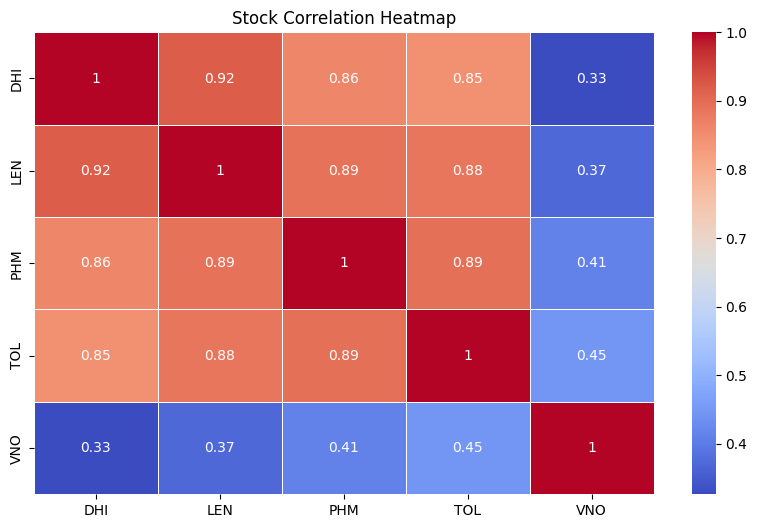

In [68]:
correlation_matrix = log_returns.corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Stock Correlation Heatmap")
plt.show()

In [69]:
correlation_threshold = 0.75
high_correlation_pairs = []

for stock1 in correlation_matrix.columns:
    for stock2 in correlation_matrix.columns:
        if stock1 != stock2:
            correlation_value = correlation_matrix.loc[stock1, stock2]
            if correlation_value > correlation_threshold:
                high_correlation_pairs.append((stock1, stock2, correlation_value))

correlated_pairs_df = pd.DataFrame(high_correlation_pairs, columns=["Stock A", "Stock B", "Correlation"])
correlated_pairs_df.sort_values("Correlation", ascending=False, inplace=True)

correlated_pairs_df.head()

,Stock A,Stock B,Correlation
0,DHI,LEN,0.920090
3,LEN,DHI,0.920090
8,PHM,TOL,0.894599
11,TOL,PHM,0.894599
4,LEN,PHM,0.892042


DHI & LEN | P-Value: 0.218
LEN & DHI | P-Value: 0.218
PHM & TOL | P-Value: 0.000
TOL & PHM | P-Value: 0.000
LEN & PHM | P-Value: 0.434
PHM & LEN | P-Value: 0.434
LEN & TOL | P-Value: 0.262
TOL & LEN | P-Value: 0.262
DHI & PHM | P-Value: 0.135
PHM & DHI | P-Value: 0.135
DHI & TOL | P-Value: 0.247
TOL & DHI | P-Value: 0.247

 Filtering for cointegrated pairs (p < 0.1)...

   Stock A Stock B  Correlation  Cointegration P-Value
8      PHM     TOL     0.894599               0.000248
11     TOL     PHM     0.894599               0.000248
DHI & LEN | P-Value: 0.218
DHI & PHM | P-Value: 0.135
DHI & TOL | P-Value: 0.247
DHI & VNO | P-Value: 0.700
LEN & PHM | P-Value: 0.434
LEN & TOL | P-Value: 0.262
LEN & VNO | P-Value: 0.882
PHM & TOL | P-Value: 0.000
PHM & VNO | P-Value: 0.897
TOL & VNO | P-Value: 0.981


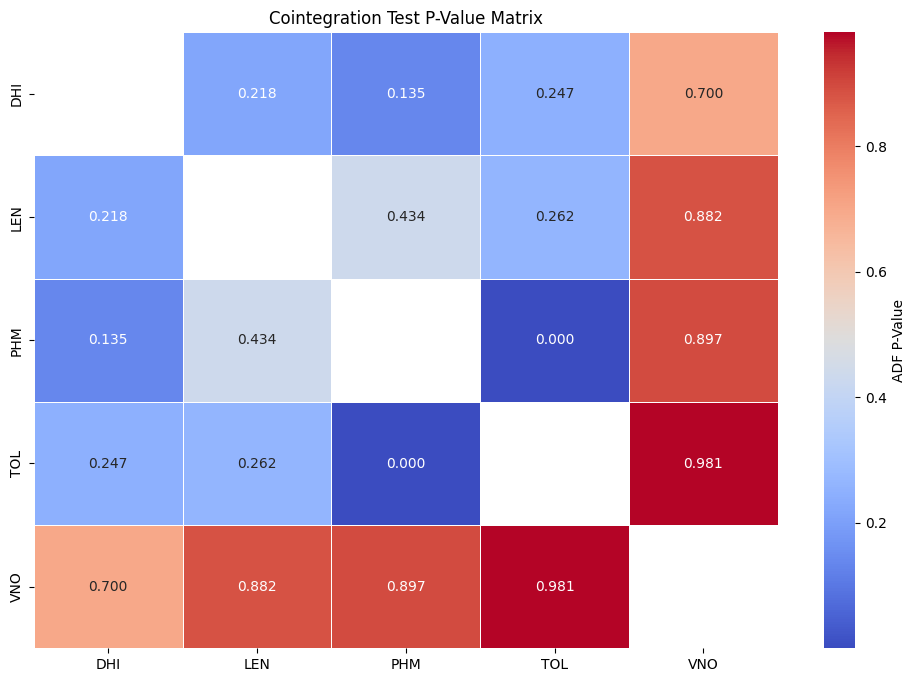

,Stock A,Stock B,Correlation,Cointegration P-Value
8,PHM,TOL,0.894599,0.000248
11,TOL,PHM,0.894599,0.000248


In [70]:
from statsmodels.tsa.stattools import adfuller

def test_cointegration(stock1, stock2):
    try:
        spread = data[stock1] - data[stock2]
        spread = spread.dropna()  
        
        if len(spread) < 30: 
            return np.nan  

        result = adfuller(spread)
        p_value = result[1]  
        print(f"{stock1} & {stock2} | P-Value: {p_value:.3f}")
        return p_value
    
    except Exception as e:
        print(f"Error with {stock1} & {stock2}: {e}")
        return np.nan  


p_values = []
for index, row in correlated_pairs_df.iterrows():
    p_value = test_cointegration(row["Stock A"], row["Stock B"])
    p_values.append(p_value)

correlated_pairs_df["Cointegration P-Value"] = p_values

print("\n Filtering for cointegrated pairs (p < 0.1)...\n")
cointegrated_pairs = correlated_pairs_df[correlated_pairs_df["Cointegration P-Value"] < 0.1]
print(cointegrated_pairs)

tickers = list(data.columns)

p_values_matrix = pd.DataFrame(np.ones((len(tickers), len(tickers))), index=tickers, columns=tickers)

for i, stock1 in enumerate(tickers):
    for j, stock2 in enumerate(tickers):
        if i < j: 
            p_value = test_cointegration(stock1, stock2)
            p_values_matrix.loc[stock1, stock2] = p_value
            p_values_matrix.loc[stock2, stock1] = p_value  

np.fill_diagonal(p_values_matrix.values, np.nan)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(p_values_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".3f", cbar_kws={'label': 'ADF P-Value'})
plt.title("Cointegration Test P-Value Matrix")
plt.show()
cointegrated_pairs.head()